In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
import numpy as np


In [46]:
dataset_dir = "/mnt/c/MyEverything/PythonProjects/Recent_projects/cnn_analysis/MiniProjectCNN/Fabric Defect Dataset/Processed_dataset/Augmented_Processed_dataset"
train_dir = dataset_dir


In [47]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  
    subset='training',
    color_mode='grayscale'
)
val_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',  
    subset='validation',
    color_mode='grayscale'
)



Found 5045 images belonging to 6 classes.
Found 1257 images belonging to 6 classes.


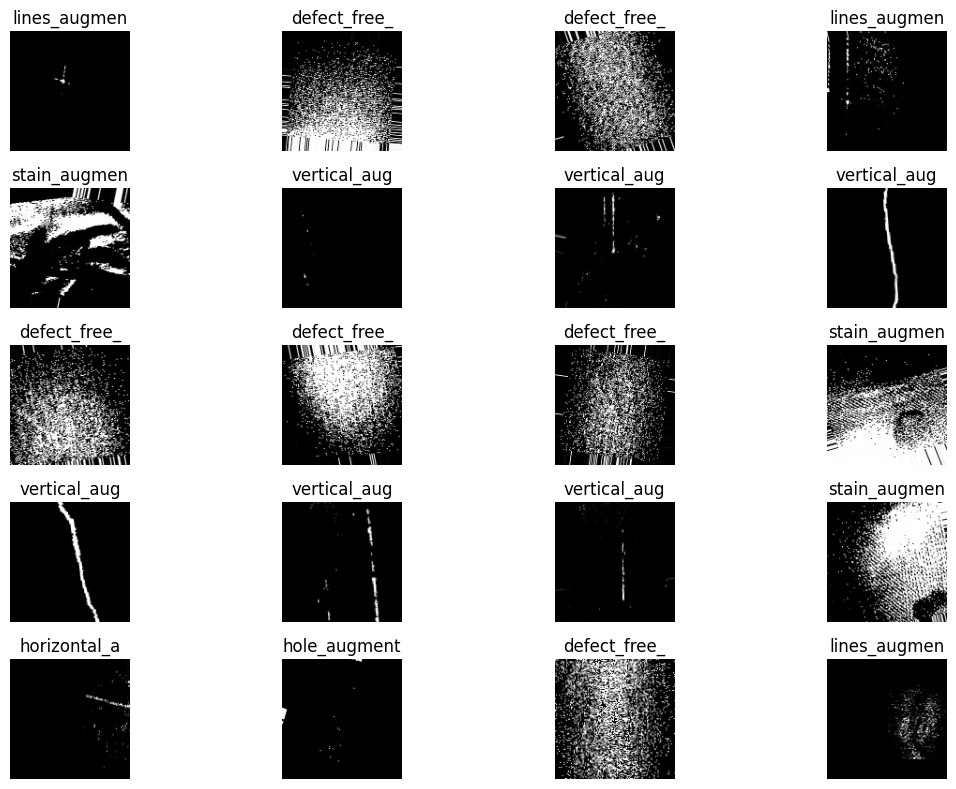

In [48]:
import matplotlib.pyplot as plt

images, labels = next(train_set) 
class_labels = {v: k for k, v in train_set.class_indices.items()}

plt.figure(figsize=(12, 8))
for i in range(20):  # note 20 here
    plt.subplot(5, 4, i + 1)        #5 x 4 = 20 lol
    plt.imshow(images[i].squeeze(), cmap='gray')  #squeeze() for grayscale images
    plt.title(f"{class_labels[np.argmax(labels[i])][0:12]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [49]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu', input_shape=[128, 128, 1]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.3))  # Dropout added after the first pooling layer

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.3))  # Dropout added after the second pooling layer

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(tf.keras.layers.Dropout(0.5))  # Dropout added after the first Dense layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
cnn.add(tf.keras.layers.Dropout(0.5))  # Dropout added after the second Dense layer

cnn.add(tf.keras.layers.Dense(units=6, activation='softmax',kernel_regularizer=l2(0.01)))  # Final output layer (categorical)


/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
with tf.device('/GPU:0'):
    cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [61]:
class_counts = {class_name: 0 for class_name in train_set.class_indices.keys()}

# `classes` contains the numeric class labels for all images in the dataset
for label in train_set.classes:
    class_name = list(train_set.class_indices.keys())[label]
    class_counts[class_name] += 1

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

# Total images
print(f"Total images in the training set: {sum(class_counts.values())}")

Class 'defect_free_processed': 892 images
Class 'hole_augmented_processed': 900 images
Class 'horizontal_augmented_processed': 820 images
Class 'lines_augmented_processed': 749 images
Class 'stain_augmented_processed': 956 images
Class 'vertical_augmented_processed': 728 images
Total images in the training set: 5045


In [62]:
# Calculate sample weights instead of class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

# Create a sample weights array
sample_weights = np.zeros(len(train_set.classes))
for idx, label in enumerate(train_set.classes):
    sample_weights[idx] = class_weights[label]


In [63]:

# Modify the generator to include sample weights
class WeightedDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, sample_weights):
        self.generator = generator
        self.sample_weights = sample_weights
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        X, y = self.generator[index]
        # Calculate the indices for this batch
        start_idx = index * self.generator.batch_size
        end_idx = min((index + 1) * self.generator.batch_size, len(self.sample_weights))
        batch_weights = self.sample_weights[start_idx:end_idx]
        return X, y, batch_weights


In [64]:

# Create weighted generators
weighted_train_set = WeightedDataGenerator(train_set, sample_weights)


In [65]:

# Training with weighted generator
with tf.device('/GPU:0'):
    history = cnn.fit(
        weighted_train_set,
        validation_data=val_set,
        epochs=50,
        callbacks=[early_stopping]
    )

/mnt/c/Windows/system32/tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 311ms/step - accuracy: 0.4140 - loss: 3.7875 - val_accuracy: 0.5147 - val_loss: 2.9553
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 287ms/step - accuracy: 0.4941 - loss: 2.7410 - val_accuracy: 0.5449 - val_loss: 2.5735
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 305ms/step - accuracy: 0.5434 - loss: 2.3481 - val_accuracy: 0.5378 - val_loss: 2.4382
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.5576 - loss: 2.1268 - val_accuracy: 0.5617 - val_loss: 2.2487
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 309ms/step - accuracy: 0.5933 - loss: 1.9360 - val_accuracy: 0.5680 - val_loss: 2.0774
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 48s 302ms/step - accuracy: 0.6249 - loss: 1.7959 - val_accuracy: 0.5704 - val_loss: 1.9995
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - accuracy: 0.6285 - loss: 1.7098 - val_accuracy: 0.5625 - val_loss: 1.9235
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 291ms/step - accuracy: 0.6466 - loss: 1

In [66]:
# with tf.device('/GPU:0'):
#     history = cnn.fit(train_set, validation_data=val_set, epochs=50, callbacks=[early_stopping])#class_weight=class_weights_dict)

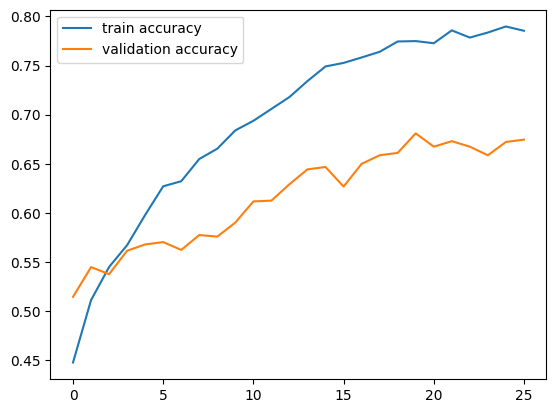

In [67]:

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()


In [68]:

# Saving the model
cnn.save('first_cnn_try_categorical.h5')


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step
[[25 45 45 16 55 37]
 [28 64 33 11 68 20]
 [32 44 44 14 45 25]
 [26 30 34 13 55 29]
 [43 52 44 12 70 17]
 [28 35 36  5 54 23]]


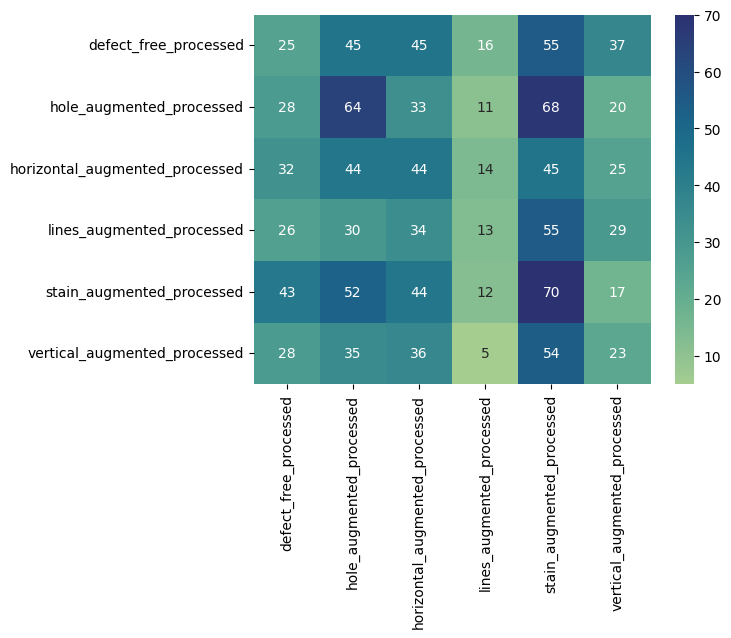


Classification Report:
                                 precision    recall  f1-score   support

         defect_free_processed       0.14      0.11      0.12       223
      hole_augmented_processed       0.24      0.29      0.26       224
horizontal_augmented_processed       0.19      0.22      0.20       204
     lines_augmented_processed       0.18      0.07      0.10       187
     stain_augmented_processed       0.20      0.29      0.24       238
  vertical_augmented_processed       0.15      0.13      0.14       181

                      accuracy                           0.19      1257
                     macro avg       0.18      0.18      0.18      1257
                  weighted avg       0.18      0.19      0.18      1257



In [69]:

# Evaluating the model
predictions = cnn.predict(val_set)
true_labels = val_set.classes
predicted_labels = np.argmax(predictions, axis=1)

# Confusion Matrix and Metrics
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
sns.heatmap(cm, annot=True, xticklabels=train_set.class_indices.keys(), yticklabels=train_set.class_indices.keys(), cmap="crest")
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=train_set.class_indices.keys())
print("\nClassification Report:\n", report)
